# Imports and configs

In [2]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import glob
import gc
import time

warnings.filterwarnings("ignore")

In [18]:
class CFG:
    train_path = "input/train.parquet"
    test_path = "input/test.parquet"
    sample_sub_path = "input/sample_submission.csv"

    target = "label"
    features_main = ['bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume']
    features_x = ['X' + str(i) for i in range(1,780+1)]

    n_folds = 3
    seed = 42

    run_optuna = True
    n_optuna_trials = 100 

# Data loading

Discussionで拾ってきたやつ。データ量を圧縮して分析効率を上げることができる。
https://www.kaggle.com/competitions/drw-crypto-market-prediction/discussion/580485

In [4]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2

    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe


In [5]:
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

X = train.drop(CFG.target, axis=1)
y = train[CFG.target]
X_test = test.drop(CFG.target, axis=1)

Reducing memory usage for: train
--- Memory usage before: 3153.58 MB
--- Memory usage after: 788.40 MB
--- Decreased memory usage by 75.0%

Reducing memory usage for: test
--- Memory usage before: 3227.13 MB
--- Memory usage after: 806.27 MB
--- Decreased memory usage by 75.0%



# Preprocessing

In [6]:
train.head()

,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,X4,X5,...,X772,X773,X774,X775,X776,X777,X778,X779,X780,label
0,15.281250,8.421875,176.3750,44.96875,221.375,0.181885,-0.637695,0.006653,0.136841,0.116699,...,0.333740,-0.009995,-0.695801,-0.444092,-0.191284,-0.184204,-0.471924,-0.625488,-0.554199,0.562500
1,38.593750,2.335938,526.0000,322.00000,848.000,0.489502,-0.075623,0.431641,0.522461,0.475342,...,0.333740,-0.010040,-0.696289,-0.452881,-0.200073,-0.188965,-0.472900,-0.625977,-0.554199,0.533691
2,0.441895,60.250000,159.2500,136.37500,295.500,0.260010,-0.444580,0.100708,0.224731,0.203247,...,0.333740,-0.010040,-0.696777,-0.461426,-0.208740,-0.193604,-0.473877,-0.626465,-0.554688,0.546387
3,4.863281,21.015625,335.7500,124.93750,460.750,0.099976,-0.666504,-0.123840,0.019196,0.014458,...,0.333252,-0.010277,-0.697266,-0.469727,-0.217407,-0.198120,-0.474609,-0.626465,-0.555176,0.357666
4,27.156250,3.451172,98.4375,44.40625,142.875,0.270996,-0.325928,0.116333,0.234253,0.214111,...,0.333252,-0.010284,-0.697754,-0.477539,-0.225830,-0.202759,-0.475586,-0.626953,-0.555664,0.362549


In [7]:

# ── 前処理 ──
# 数値列のみ抽出（X1～X200）重すぎるので。
X_num = X[CFG.features_x].select_dtypes(include=[np.number])

# ∞ を NaN に置換
X_num = X_num.replace([np.inf, -np.inf], np.nan)

# 欠損を各列の中央値で埋める
X_clean = X_num.fillna(X_num.median())

# まだ NaN を含む列を丸ごと除外
X_clean = X_clean.dropna(axis=1, how='any')

# float32 にダウンキャスト
X_clean = X_clean.astype(np.float32)

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

null_counts = X_clean.isnull().sum()
print(f"Null counts per column:")
print(null_counts[null_counts > 0])

X_clean.head()

Null counts per column:
Series([], dtype: int64)


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X771,X772,X773,X774,X775,X776,X777,X778,X779,X780
0,0.181885,-0.637695,0.006653,0.136841,0.116699,0.050171,0.063416,0.118408,1.499023,-0.058380,...,-0.868164,0.333740,-0.009995,-0.695801,-0.444092,-0.191284,-0.184204,-0.471924,-0.625488,-0.554199
1,0.489502,-0.075623,0.431641,0.522461,0.475342,0.380615,0.383789,0.433350,1.364258,-0.362549,...,0.194214,0.333740,-0.010040,-0.696289,-0.452881,-0.200073,-0.188965,-0.472900,-0.625977,-0.554199
2,0.260010,-0.444580,0.100708,0.224731,0.203247,0.133057,0.144287,0.198120,1.283203,-0.517578,...,0.270508,0.333740,-0.010040,-0.696777,-0.461426,-0.208740,-0.193604,-0.473877,-0.626465,-0.554688
3,0.099976,-0.666504,-0.123840,0.019196,0.014458,-0.039398,-0.022705,0.034119,1.026367,-1.058594,...,0.425781,0.333252,-0.010277,-0.697266,-0.469727,-0.217407,-0.198120,-0.474609,-0.626465,-0.555176
4,0.270996,-0.325928,0.116333,0.234253,0.214111,0.144409,0.155396,0.208984,1.075195,-0.851562,...,0.445068,0.333252,-0.010284,-0.697754,-0.477539,-0.225830,-0.202759,-0.475586,-0.626953,-0.555664


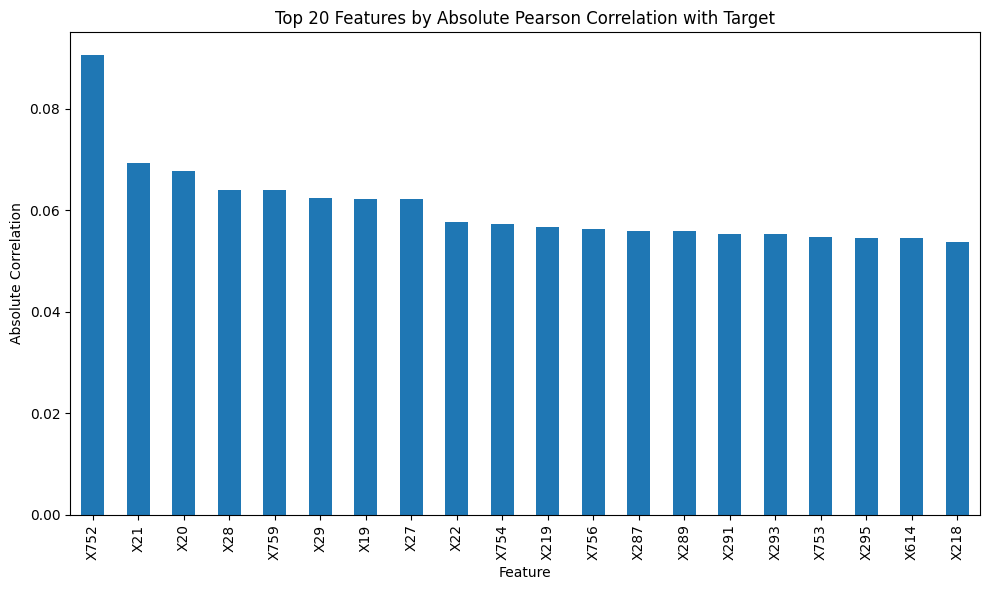

In [8]:
# Pearson correlation
corr = X_clean.corrwith(y)
corr_abs = corr.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_abs.iloc[:20].plot.bar()
plt.title('Top 20 Features by Absolute Pearson Correlation with Target')
plt.ylabel('Absolute Correlation')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [9]:
import lightgbm as lgb

# 学習用データセットを作成
dtrain = lgb.Dataset(X_clean, label=y)

# GPUを使うためのパラメータ
params = {
    'objective': 'regression',   # 回帰問題
    'metric': 'rmse',            # 評価指標（RMSE）
    'device': 'gpu',             # ← ここでGPU指定
    'gpu_platform_id': 0,        # OpenCLプラットフォームID。通常は0
    'gpu_device_id': 0,          # GPUデバイスID。通常は0
    'learning_rate': 0.1,
    'num_leaves': 64,
    'max_depth': 7,
}

# ごく少量のブーストラウンドで動作確認
gbm = lgb.train(
    params,
    dtrain,
    num_boost_round=100,
    callbacks=[lgb.log_evaluation(5)]
)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 198893
[LightGBM] [Info] Number of data points in the train set: 525886, number of used features: 780
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 772 dense feature groups (387.18 MB) transferred to GPU in 0.106996 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.036126


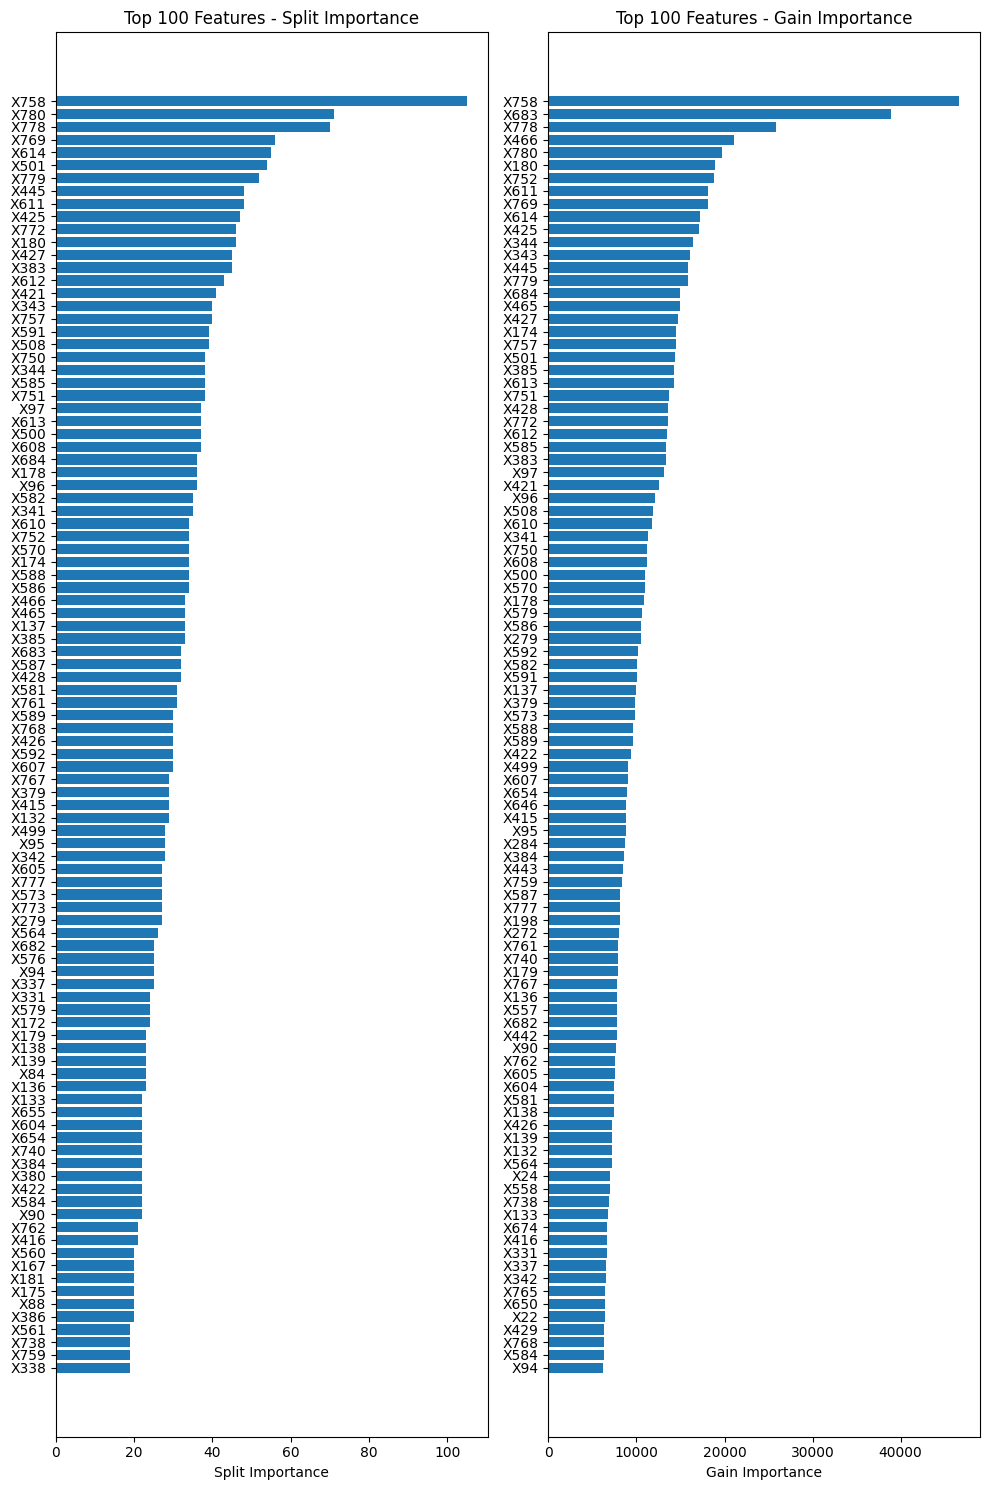

=== Top 10 Features by Gain Importance ===
    feature  gain_importance
757    X758     46670.992146
682    X683     38910.568783
777    X778     25893.654671
465    X466     21064.609474
779    X780     19666.493324
179    X180     18942.536453
751    X752     18796.673950
610    X611     18164.246086
768    X769     18097.019335
613    X614     17266.860352

=== Top 10 Features by Split Importance ===
    feature  split_importance
757    X758               105
779    X780                71
777    X778                70
768    X769                56
613    X614                55
500    X501                54
778    X779                52
444    X445                48
610    X611                48
424    X425                47

=== Importance Statistics ===
Total features: 780
Features with gain > 0: 609
Top feature (gain): X758 = 46670.9921


In [10]:
# LightGBM 変数重要度の取得と可視化
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Split importance（分岐回数ベース）
split_importance = gbm.feature_importance(importance_type='split')
split_importance_df = pd.DataFrame({
    'feature': X_clean.columns,
    'split_importance': split_importance
}).sort_values('split_importance', ascending=False)

# 2. Gain importance（ゲインベース - より重要）
gain_importance = gbm.feature_importance(importance_type='gain')
gain_importance_df = pd.DataFrame({
    'feature': X_clean.columns,
    'gain_importance': gain_importance
}).sort_values('gain_importance', ascending=False)

# 3. 可視化
fig, axes = plt.subplots(1, 2, figsize=(10, 15))

# Split importance のプロット
axes[0].barh(split_importance_df.head(100)['feature'], 
             split_importance_df.head(100)['split_importance'])
axes[0].set_title('Top 100 Features - Split Importance')
axes[0].set_xlabel('Split Importance')
axes[0].invert_yaxis()

# Gain importance のプロット
axes[1].barh(gain_importance_df.head(100)['feature'], 
             gain_importance_df.head(100)['gain_importance'])
axes[1].set_title('Top 100 Features - Gain Importance')
axes[1].set_xlabel('Gain Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# 4. 上位重要度の数値表示
print("=== Top 10 Features by Gain Importance ===")
print(gain_importance_df.head(10))

print("\n=== Top 10 Features by Split Importance ===")
print(split_importance_df.head(10))

# 5. 重要度の要約統計
print(f"\n=== Importance Statistics ===")
print(f"Total features: {len(X_clean.columns)}")
print(f"Features with gain > 0: {(gain_importance > 0).sum()}")
print(f"Top feature (gain): {gain_importance_df.iloc[0]['feature']} = {gain_importance_df.iloc[0]['gain_importance']:.4f}")

In [13]:
top_50_features = gain_importance_df.head(50)['feature']

features = [
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume",
    *top_50_features,
]

X = X[features]
X_test = X_test[features]

# Training base model

In [19]:
# 共通設定
kf = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)

In [20]:
def pearson_score(y_true, y_pred):
    """Pearson相関スコア"""
    return pearsonr(y_true, y_pred)[0]

In [21]:

def run_cross_validation(model, X, y, model_name="Model", cv_folds=None):
    """
    fold別詳細結果表示対応クロスバリデーション関数
    
    Parameters:
    -----------
    model : sklearn compatible model
        学習させるモデル
    X : pandas.DataFrame
        特徴量データ
    y : pandas.Series
        目的変数
    model_name : str
        モデル名
    cv_folds : KFold object
        クロスバリデーション設定
    
    Returns:
    --------
    dict : CV結果の辞書
    """
    
    if cv_folds is None:
        cv_folds = KFold(n_splits=CFG.n_folds, shuffle=False, random_state=None)
    
    print(f"=== {model_name} Cross Validation 開始 ===")
    
    # 結果保存用
    fold_results = []
    rmse_scores = []
    r2_scores = []
    pearson_scores = []
    times = []
    
    # 各fold実行
    for fold, (train_idx, val_idx) in enumerate(cv_folds.split(X, y)):
        start_time = time.time()
        
        # データ分割
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # モデル学習
        model.fit(X_train, y_train)
        
        # 予測
        y_pred = model.predict(X_val)
        
        # 評価指標計算
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        pearson = pearsonr(y_val, y_pred)[0]
        
        # 実行時間
        fold_time = time.time() - start_time
        
        # 結果保存
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        pearson_scores.append(pearson)
        times.append(fold_time)
        
        fold_results.append({
            'fold': fold,
            'rmse': rmse,
            'r2': r2,
            'pearson': pearson,
            'time': fold_time
        })
        
        # fold別結果表示
        print(f"--- Fold {fold} - pearsonr: {pearson:.6f} - Time: {fold_time:.2f} s")
    
    # 全体統計
    results = {
        'fold_results': fold_results,
        'rmse': {
            'mean': np.mean(rmse_scores),
            'std': np.std(rmse_scores),
            'scores': rmse_scores
        },
        'r2': {
            'mean': np.mean(r2_scores),
            'std': np.std(r2_scores),
            'scores': r2_scores
        },
        'pearson': {
            'mean': np.mean(pearson_scores),
            'std': np.std(pearson_scores),
            'scores': pearson_scores
        },
        'time': {
            'mean': np.mean(times),
            'total': np.sum(times)
        }
    }
    
    # 全体結果表示
    print(f"\n{model_name} Overall Results:")
    print(f"  RMSE: {results['rmse']['mean']:.6f} ± {results['rmse']['std']:.6f}")
    print(f"  R²: {results['r2']['mean']:.6f} ± {results['r2']['std']:.6f}")
    print(f"  Pearson: {results['pearson']['mean']:.6f} ± {results['pearson']['std']:.6f}")
    print(f"  Total Time: {results['time']['total']:.2f} s")
    print()
    
    return results

## LightGBM (gbdt)

In [22]:
print("📊 LightGBM学習開始")
lgbm_model = LGBMRegressor(
    objective='regression',
    device='gpu',
    gpu_platform_id=0,
    gpu_device_id=0,
    learning_rate=0.1,
    num_leaves=64,
    max_depth=7,
    n_estimators=1000,
    verbose=-1
)

lgbm_results = run_cross_validation(
    model=lgbm_model,
    X=X,
    y=y,
    model_name="LightGBM",
    cv_folds=kf
)

📊 LightGBM学習開始
=== LightGBM Cross Validation 開始 ===
--- Fold 0 - pearsonr: 0.969000 - Time: 14.15 s
--- Fold 1 - pearsonr: 0.968517 - Time: 14.14 s
--- Fold 2 - pearsonr: 0.969843 - Time: 14.06 s

LightGBM Overall Results:
  RMSE: 0.255235 ± 0.002086
  R²: 0.936124 ± 0.000986
  Pearson: 0.969120 ± 0.000548
  Total Time: 42.35 s



## XGBoost

In [23]:
print("📊 XGBoost学習開始")
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    tree_method='gpu_hist',
    learning_rate=0.1,
    max_depth=7,
    n_estimators=1000,
    verbosity=0
)

xgb_results = run_cross_validation(
    model=xgb_model,
    X=X,
    y=y,
    model_name="XGBoost",
    cv_folds=kf
)

📊 XGBoost学習開始
=== XGBoost Cross Validation 開始 ===
--- Fold 0 - pearsonr: 0.975307 - Time: 10.61 s
--- Fold 1 - pearsonr: 0.974950 - Time: 10.37 s
--- Fold 2 - pearsonr: 0.975992 - Time: 10.47 s

XGBoost Overall Results:
  RMSE: 0.227468 ± 0.001915
  R²: 0.949266 ± 0.000804
  Pearson: 0.975417 ± 0.000432
  Total Time: 31.44 s



## NN

In [24]:
# CPU用に最適化されたMLP
print("🏃‍♂️ 最適化MLP (CPU) 学習開始")

optimized_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(
        hidden_layer_sizes=(128, 64),  # 層を減らして高速化
        activation='relu',
        solver='adam',
        alpha=0.01,  # 正則化を強めて過学習抑制
        batch_size=200,  # バッチサイズを大きくして高速化
        learning_rate='adaptive',
        learning_rate_init=0.01,
        max_iter=300,  # 反復数を減らして高速化
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20  # 早期停止を早めて高速化
    ))
])

optimized_mlp_results = run_cross_validation(
    model=optimized_mlp,
    X=X,
    y=y,
    model_name="Optimized MLP (CPU)",
    cv_folds=kf
)

🏃‍♂️ 最適化MLP (CPU) 学習開始
=== Optimized MLP (CPU) Cross Validation 開始 ===
--- Fold 0 - pearsonr: 0.808694 - Time: 182.67 s
--- Fold 1 - pearsonr: 0.824957 - Time: 277.83 s
--- Fold 2 - pearsonr: 0.817329 - Time: 264.28 s

Optimized MLP (CPU) Overall Results:
  RMSE: 0.582909 ± 0.010265
  R²: 0.666762 ± 0.011384
  Pearson: 0.816993 ± 0.006644
  Total Time: 724.79 s



# Ensemble

In [26]:

def create_ensemble_predictions(trained_models, model_names, X, y, X_test, cv_folds):
    """
    学習済みモデルを使ってアンサンブル用の予測を作成
    
    Parameters:
    -----------
    trained_models : dict
        学習済みモデルの辞書 {'model_name': model}
    model_names : list
        使用するモデル名のリスト
    X, y : DataFrame, Series
        学習データ
    X_test : DataFrame
        テストデータ
    cv_folds : KFold
        クロスバリデーション設定
        
    Returns:
    --------
    oof_predictions : DataFrame
        Out-of-Fold予測データフレーム
    test_predictions : DataFrame
        テストデータ予測データフレーム
    """
    
    print("🔄 学習済みモデルでアンサンブル予測作成中...")
    
    # 結果保存用辞書
    oof_preds = {}
    test_preds = {}
    
    for model_name in model_names:
        print(f"  📊 {model_name} のアンサンブル予測作成中...")
        
        # OOF予測用配列初期化
        oof_pred = np.zeros(len(X))
        test_pred_folds = []
        
        # 各foldで予測
        for fold, (train_idx, val_idx) in enumerate(cv_folds.split(X, y)):
            # データ分割
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # 学習済みモデルをクローンして再学習
            # (学習済みパラメータを使用するため、同じ設定で学習)
            fold_model = clone(trained_models[model_name])
            fold_model.fit(X_train, y_train)
            
            # OOF予測
            oof_pred[val_idx] = fold_model.predict(X_val)
            
            # テストデータ予測
            test_pred_folds.append(fold_model.predict(X_test))
            
        # テストデータ予測の平均
        test_pred = np.mean(test_pred_folds, axis=0)
        
        # 結果保存
        oof_preds[model_name] = oof_pred
        test_preds[model_name] = test_pred
        
        # OOF性能確認
        oof_pearson = pearsonr(y, oof_pred)[0]
        print(f"    ✅ {model_name} OOF Pearson: {oof_pearson:.6f}")
    
    # DataFrameに変換
    oof_df = pd.DataFrame(oof_preds)
    test_df = pd.DataFrame(test_preds)
    
    return oof_df, test_df

In [27]:

def optimize_ridge_alpha(oof_predictions, y, alphas=None):
    """
    Ridge回帰のalphaパラメータを最適化
    
    Parameters:
    -----------
    oof_predictions : DataFrame
        OOF予測データフレーム
    y : Series
        目的変数
    alphas : list
        試行するalphaの値リスト
        
    Returns:
    --------
    best_alpha : float
        最適なalpha値
    """
    
    if alphas is None:
        alphas = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
    
    print("🔍 Ridge alpha パラメータ最適化中...")
    
    best_alpha = None
    best_score = -np.inf
    
    for alpha in alphas:
        ridge = Ridge(alpha=alpha, random_state=CFG.seed)
        
        # クロスバリデーションでスコア計算
        scores = cross_val_score(
            ridge, oof_predictions, y, 
            cv=5, 
            scoring='neg_mean_squared_error'
        )
        mean_score = scores.mean()
        
        print(f"  alpha={alpha:>6}: CV Score = {-mean_score:.6f}")
        
        if mean_score > best_score:
            best_score = mean_score
            best_alpha = alpha
    
    print(f"✅ 最適alpha: {best_alpha}")
    return best_alpha

In [28]:
def ridge_ensemble_final(oof_predictions, test_predictions, y, alpha=None):
    """
    Ridgeでアンサンブルモデルを学習・予測
    
    Parameters:
    -----------
    oof_predictions : DataFrame
        OOF予測データフレーム
    test_predictions : DataFrame  
        テストデータ予測データフレーム
    y : Series
        目的変数
    alpha : float
        Ridge正則化パラメータ（Noneの場合は最適化）
        
    Returns:
    --------
    ridge_model : Ridge
        学習済みRidgeモデル
    final_predictions : ndarray
        最終アンサンブル予測
    model_weights : ndarray
        各モデルの重み
    """
    
    print("Ridge Ensemble 最終学習開始")
    
    # alpha最適化（指定されていない場合）
    if alpha is None:
        alpha = optimize_ridge_alpha(oof_predictions, y)
    
    # Ridge学習
    ridge_model = Ridge(alpha=alpha, random_state=CFG.seed)
    ridge_model.fit(oof_predictions, y)
    
    # 最終予測
    final_predictions = ridge_model.predict(test_predictions)
    
    # モデル重み取得
    model_weights = ridge_model.coef_
    
    print(f"\n📈 Ridge Ensemble Results (alpha={alpha}):")
    print(f"  切片: {ridge_model.intercept_:.6f}")
    print(f"  モデル重み:")
    for name, weight in zip(oof_predictions.columns, model_weights):
        print(f"    {name}: {weight:.6f}")
    
    # OOFでの性能確認
    oof_ensemble_pred = ridge_model.predict(oof_predictions)
    oof_pearson = pearsonr(y, oof_ensemble_pred)[0]
    oof_rmse = np.sqrt(mean_squared_error(y, oof_ensemble_pred))
    
    print(f"\n✅ Ridge Ensemble OOF Performance:")
    print(f"  Pearson: {oof_pearson:.6f}")
    print(f"  RMSE: {oof_rmse:.6f}")
    
    return ridge_model, final_predictions, model_weights

In [29]:
def plot_weights(weights, model_names, title="Model Weights", figsize=(10, 6)):
    """
    アンサンブルモデルの重みを可視化する関数
    
    Parameters:
    -----------
    weights : array-like
        モデルの重み（係数）
    model_names : list
        モデル名のリスト
    title : str
        グラフのタイトル
    figsize : tuple
        図のサイズ
    """
    
    # 入力データの検証
    if len(weights) != len(model_names):
        raise ValueError(f"重みの数({len(weights)})とモデル名の数({len(model_names)})が一致しません")
    
    # weightsが2次元配列の場合は1次元に変換
    if isinstance(weights, np.ndarray) and weights.ndim == 2:
        weights = weights.flatten()
    
    # 降順でソート
    sorted_indices = np.argsort(weights)[::-1]
    sorted_coeffs = np.array(weights)[sorted_indices]
    sorted_model_names = np.array(model_names)[sorted_indices]
    
    # グラフサイズを動的に調整
    height = max(len(model_names) * 0.5, 4)  # 最小4, モデル数に応じて調整
    
    plt.figure(figsize=(figsize[0], height))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")
    
    # 数値ラベルの追加
    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value + 0.01, i, f"{value:.3f}", va="center", ha="left", color="black", fontweight='bold')
        else:
            ax.text(value - 0.01, i, f"{value:.3f}", va="center", ha="right", color="black", fontweight='bold')
    
    # x軸の範囲を調整（ラベルが見えるように）
    xlim = ax.get_xlim()
    x_range = xlim[1] - xlim[0]
    ax.set_xlim(xlim[0] - 0.15 * x_range, xlim[1] + 0.15 * x_range)
    
    # グラフの装飾
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("Weight", fontsize=12)
    plt.ylabel("Model", fontsize=12)
    
    # 0の線を追加（負の重みがある場合）
    if np.any(sorted_coeffs < 0):
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5, linewidth=1)
    
    plt.tight_layout()
    plt.show()
    
    # 重み情報をテキストでも表示
    print(f"\n📊 {title}")
    print("="*50)
    for name, weight in zip(sorted_model_names, sorted_coeffs):
        print(f"{name:15}: {weight:8.6f}")
    print("="*50)
    total_abs_weight = np.sum(np.abs(sorted_coeffs))
    print(f"{'Total |Weight|':15}: {total_abs_weight:8.6f}")

In [30]:
# 学習済みモデルを辞書にまとめる
trained_models = {
    'LightGBM': lgbm_model,
    'XGBoost': xgb_model, 
    'MLP': optimized_mlp
}

model_names = ['LightGBM', 'XGBoost', 'MLP']

print("🚀 Ridge Ensemble Pipeline 開始")
print(f"📊 使用モデル: {model_names}")

# 1. アンサンブル用予測作成
oof_predictions, test_predictions = create_ensemble_predictions(
    trained_models=trained_models,
    model_names=model_names,
    X=X,
    y=y,
    X_test=X_test,
    cv_folds=kf
)

print(f"\n📋 アンサンブル予測データ形状:")
print(f"  OOF予測: {oof_predictions.shape}")
print(f"  テスト予測: {test_predictions.shape}")

🚀 Ridge Ensemble Pipeline 開始
📊 使用モデル: ['LightGBM', 'XGBoost', 'MLP']
🔄 学習済みモデルでアンサンブル予測作成中...
  📊 LightGBM のアンサンブル予測作成中...
    ✅ LightGBM OOF Pearson: 0.969131
  📊 XGBoost のアンサンブル予測作成中...
    ✅ XGBoost OOF Pearson: 0.975413
  📊 MLP のアンサンブル予測作成中...
    ✅ MLP OOF Pearson: 0.816575

📋 アンサンブル予測データ形状:
  OOF予測: (525886, 3)
  テスト予測: (538150, 3)


In [31]:
# 2. Ridge Ensemble学習・予測
ridge_model, ensemble_predictions, model_weights = ridge_ensemble_final(
    oof_predictions=oof_predictions,
    test_predictions=test_predictions,
    y=y,
    alpha=None  # 自動最適化
)

Ridge Ensemble 最終学習開始
🔍 Ridge alpha パラメータ最適化中...
  alpha=  0.01: CV Score = 0.048683
  alpha=   0.1: CV Score = 0.048683
  alpha=   0.5: CV Score = 0.048683
  alpha=   1.0: CV Score = 0.048683
  alpha=   2.0: CV Score = 0.048683
  alpha=   5.0: CV Score = 0.048683
  alpha=  10.0: CV Score = 0.048683
  alpha=  20.0: CV Score = 0.048683
✅ 最適alpha: 20.0

📈 Ridge Ensemble Results (alpha=20.0):
  切片: -0.001487
  モデル重み:
    LightGBM: 0.201689
    XGBoost: 0.887783
    MLP: -0.045703

✅ Ridge Ensemble OOF Performance:
  Pearson: 0.975861
  RMSE: 0.220559


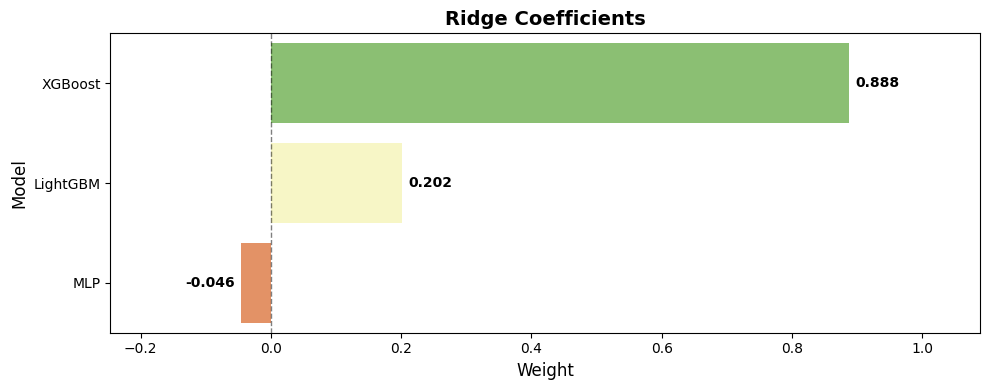


📊 Ridge Coefficients
XGBoost        : 0.887783
LightGBM       : 0.201689
MLP            : -0.045703
Total |Weight| : 1.135174


In [32]:
plot_weights(
    weights=model_weights,  # 1次元配列
    model_names=list(oof_predictions.columns),  # DataFrameのカラム名から取得
    title="Ridge Coefficients"
)

# Submission

In [33]:
# スコア計算
ridge_oof_score = pearson_score(y, ridge_model.predict(oof_predictions))

# 提出ファイル
sub = pd.read_csv(CFG.sample_sub_path)
sub["prediction"] = ensemble_predictions
sub.to_csv(f"output/sub_ridge_{ridge_oof_score:.6f}.csv", index=False)


In [34]:
sub.head()

,ID,prediction
0,1,0.722826
1,2,1.520665
2,3,-0.461899
3,4,0.397858
4,5,1.574213
